# Calculate sigmav vs. mDM for simulated DM datasets

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from gammapy.astro.darkmatter.utils import SigmaVEstimator
from gammapy.spectrum import SpectrumDatasetOnOff, CountsSpectrum
from gammapy.astro.darkmatter import DMAnnihilation
from gammapy.irf import load_cta_irfs

## Define parameters for simulated observation

In [2]:
# -
livetime = 100 * u.h # in hours
offset = 0.5 * u.deg
GLON=0 * u.deg  # -> convert to ALtAz
GLAT=0 * u.deg  # -> convert to ALtAz

# Energy from 0.01 to 100 TeV with 20 bins/decade
energy = np.logspace(-1.8, 1.5, 20) * u.TeV

# Energy true wider range and higher number of bins
energy_true = np.logspace(-2, 2, 100) * u.TeV

# DMAnnihilation Model
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # point source
mDM = 5000*u.Unit("GeV")
channel = "b"
redshift = 0

## Build IRFs with the defined parameters

In [3]:
# Load IRFs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
cta_irf = load_cta_irfs(filename)

NDDataArray summary info
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 5371581.000 m2



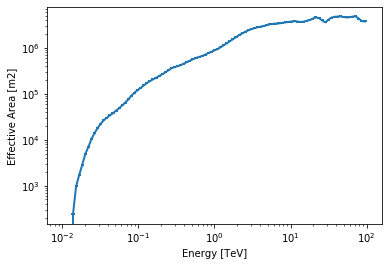

In [4]:
aeff = cta_irf["aeff"].to_effective_area_table(offset=offset, energy=energy_true)
aeff.plot()
plt.loglog()
print(cta_irf["aeff"].data)

NDDataArray summary info
MapAxis

	name       : e_true    
	unit       : 'TeV'     
	nbins      : 99        
	node type  : edges     
	edges min  : 1.0e-02 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       
MapAxis

	name       : e_reco    
	unit       : 'TeV'     
	nbins      : 19        
	node type  : edges     
	edges min  : 1.6e-02 TeV
	edges max  : 3.2e+01 TeV
	interp     : log       
Data           : size =  1881, min =  0.000, max =  0.997



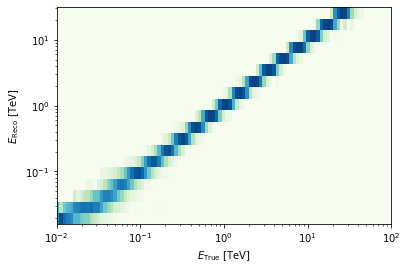

In [5]:
edisp = cta_irf["edisp"].to_energy_dispersion(
    offset=offset, e_true=energy_true, e_reco=energy
)
edisp.plot_matrix()
print(edisp.data)

## Build the background counts from PSF and IRF background

In [6]:
containment = 0.68
energies = np.sqrt(energy[1:] * energy[:-1])
psf = cta_irf["psf"].to_energy_dependent_table_psf(theta=offset)
on_radii = psf.containment_radius(energy=energies, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

#
aeff.data.data *= containment

In [7]:
bkg_data = cta_irf["bkg"].evaluate_integrate(
    fov_lon=GLON, fov_lat=GLAT, energy_reco=energy
)
bkg = CountsSpectrum(
    energy[:-1],
    energy[1:],
    data=(bkg_data * solid_angles).to_value("h-1")*livetime
)

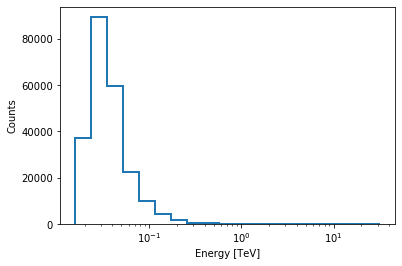

In [8]:
bkg.plot_hist()

## Simulate OnOff observation with DM emission model

In [70]:
from gammapy.modeling import Fit
from gammapy.modeling import Parameter

class DMDatasetOnOff(SpectrumDatasetOnOff):
    
    def __init__(self, nuissance, **kwargs):
        super().__init__(**kwargs)
        self.parameters.parameters
        self.parameters.parameters += [Parameter("tau", nuissance["tauobs"], frozen=False)]
        self.nuissance = nuissance
    
    def likelihood(self):
        wstat = super().likelihood()
        likeg_res = self.likeg()
        likej_res = self.likej()
        #liketotal = wstat * likegres * likejres
        liketotal = wstat * likegres
        #liketotal = wstat
        print("WSTAT:", wstat, "GLIKE:", likeg_res, "JLIKE:", likej_res)
        print(self.parameters.parameters[0].value)
        print("TOTAL:", liketotal)
        print("")
        return liketotal

    def likeg(self):
        exp_up = (self.parameters.parameters[1].value - self.nuissance["tauobs"])**2
        exp_down = 2*(self.nuissance["sigmatau"]**2)
        up = np.exp(-1*exp_up/exp_down)
        down = np.sqrt(2*np.pi)*self.nuissance["sigmatau"]
        res = up/down
        #print(up, down, res)
        return res
    
    def likej(self):
        exp_up = (np.log10(self.parameters.parameters[0].value) - np.log10(self.nuissance["jobs"].value))**2
        exp_down = 2*(self.nuissance["sigmaj"]**2)
        up = np.exp(-1*exp_up/exp_down)
        down = np.log(10)*self.nuissance["jobs"].value*np.sqrt(2*np.pi)*self.nuissance["sigmaj"]
        res = up/down
        #print(up, down, res)
        return res

In [71]:
# DM Flux
flux_model = DMAnnihilation(
    mass=mDM, 
    channel=channel, 
    jfactor=JFAC, 
    z=redshift
)

In [72]:
nuissance = dict(
    jobs=JFAC,
    sigmaj=100,
    tauobs=5,
    sigmatau=0.1
)

In [73]:
dataset = DMDatasetOnOff(
    nuissance=nuissance,
    aeff=aeff,
    edisp=edisp,
    model=flux_model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)

In [74]:
dataset.parameters.parameters[0].frozen = False

In [75]:
dataset.fake(background_model=bkg) #simulation
fit = Fit(dataset)
fit_result = fit.run()
#likelihood_profile_opts=dict(bounds=10, nvalues=50)
#likelihood_profile_opts["parameter"] = "jfactor"
#fit_ds.likelihood_profile(**likelihood_profile_opts)
jfactor_best = fit_result.parameters["jfactor"].value
tau_best = fit_result.parameters["tau"].value
print(jfactor_best, tau_best)

WSTAT: 31.54945425879396 GLIKE: 3.989422804014327 JLIKE: 5.0808924039953665e-23
3.41e+19
TOTAL: 31.54945425879396

WSTAT: 31.549295305963817 GLIKE: 3.989422804014327 JLIKE: 5.0808924035845024e-23
3.42e+19
TOTAL: 31.549295305963817

WSTAT: 31.549613382091707 GLIKE: 3.989422804014327 JLIKE: 5.0808924035820856e-23
3.4000000000000004e+19
TOTAL: 31.549613382091707

WSTAT: 31.547944695775897 GLIKE: 3.989422804014327 JLIKE: 5.080892367504537e-23
3.5054142409981223e+19
TOTAL: 31.547944695775897

WSTAT: 31.5509796194648 GLIKE: 3.989422804014327 JLIKE: 5.080892365403815e-23
3.3145857590018777e+19
TOTAL: 31.5509796194648

WSTAT: 31.54945425879396 GLIKE: 3.9695254747701187 JLIKE: 5.0808924039953665e-23
3.41e+19
TOTAL: 31.54945425879396

WSTAT: 31.54945425879396 GLIKE: 3.9695254747701187 JLIKE: 5.0808924039953665e-23
3.41e+19
TOTAL: 31.54945425879396

WSTAT: 31.54945425879396 GLIKE: 2.4197072451914425 JLIKE: 5.0808924039953665e-23
3.41e+19
TOTAL: 31.54945425879396

WSTAT: 31.54945425879396 GLIKE: 2

In [76]:
fit_result.parameters.to_table()

name,value,error,unit,min,max,frozen
str7,float64,float64,str9,float64,float64,bool
jfactor,1.258e+20,nan,cm-5 GeV2,nan,nan,False
tau,5.000e+00,nan,,nan,nan,False


In [59]:
#type(dataset.model.spectral_model)